### Loading libraries and dependencies

In [2]:
#specify the packages of interest
options(warn=-1)
options(repr.plot.width=6, repr.plot.height=4)

packages = c("haven", "tidyverse", "plyr", "ggplot2", "dplyr", "NonpModelCheck")

## Check to see if package is available and load else install the package and its dependencies
package.check <- lapply(packages, FUN = function(x) {
  if (!require(x, character.only = TRUE)) {
    install.packages(x, dependencies = TRUE)
    library(x, character.only = TRUE)
  }
})

Loading required package: haven
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The followi

### Data Preprocessing

In [3]:
##Read in data
childrenfinal <- read_dta("data/childrenfinal.dta")

## Remove specific columns with a regex expression
pattern <- "^[s,m,v]\\d"
cols <- grep(pattern, names(childrenfinal), value=T)
childrenfinal <- childrenfinal[ , !(names(childrenfinal) %in% cols)]

## Select data subset
col_subset = c("hypage","zwast")
children_subset <- childrenfinal%>%select(col_subset)

In [4]:
## Kernel functions

uniform <- function(x) (abs(x) < 1) * 0.5
triangular <- function(x) (abs(x) < 1) * (1 - abs(x))
gaussian <- function(x) 1/sqrt(2*pi) * exp(-(x^2)/2)
epanechnikov <- function(x) (abs(x) < 1) * (0.75 * (1 - x^2))

k.names <- list("uniform", "triangular", "epanechnikov", "gaussian")
k.funtions <- list(uniform, triangular, epanechnikov, gaussian)

### Local Polynomial Regression

In [5]:
#local polynomial fit function

local_polynomial <- function(Y, X, bw, l, kernel = "epanechnikov"){
  # Y = response variable
  # X = covariate
  # bw = bandwidth
  # l = polynomial degree
  # kernel = epanechnikov by default
  
  kernel <- k.funtions[[which(k.names == kernel)]]
  Y <- as.matrix(Y)
  X <- as.matrix(X)
  d <- ncol(X)
  n <- nrow(X)
  X_mat <- matrix(0, d*n, l+1)
  
  A.hat <- function(x, derivative){
    # derivative = f derivative approximated. NB: derivative poly degree <= 1
    term1 <- (X - x)/bw
    term2 <- as.vector(t(X - x))
    
    V <- apply(term1, MARGIN = 1, FUN = kernel)
    
    for (i in 0:l){
      X_mat[ ,i+1] <- term2^i
    }
  res <- lm(Y ~ X_mat - 1, weights = V) # weighted least squares (exclude intercept)
  res <- res$coefficients
  res <- factorial(derivative)*res[derivative + 1]
  return(res)
  }
    
  VA.hat <- Vectorize(A.hat, vectorize.args = "x")
  return(VA.hat)
}

In [6]:
#First fix the polynomial degree to 1 and estimate f with 4 different bandwidths
fit_1 <-local_polynomial(children_subset$zwast, children_subset$hypage, bw = 2, l = 1)
fit_2 <-local_polynomial(children_subset$zwast, children_subset$hypage, bw = 5, l = 1)
fit_3 <-local_polynomial(children_subset$zwast, children_subset$hypage, bw = 8, l = 1)
fit_4 <-local_polynomial(children_subset$zwast, children_subset$hypage, bw = 11, l = 1)

In [7]:
#Fitting on the domain of hypage
mininum = min(children_subset$hypage)
maximum = max(children_subset$hypage)

dfit.1 <- fit_1(x = 0:maximum, derivative = 0)
dfit.2 <- fit_2(x = 0:maximum, derivative = 0)
dfit.3 <- fit_3(x = 0:maximum, derivative = 0)
dfit.4 <- fit_4(x = 0:maximum, derivative = 0)

In [8]:
#dataframes for ggplot
df1 <- data.frame(a = 0:maximum, b = dfit.1)
df2 <- data.frame(a = 0:maximum, b = dfit.2)
df3 <- data.frame(a = 0:maximum, b = dfit.3)
df4 <- data.frame(a = 0:maximum, b = dfit.4)

Don't know how to automatically pick scale for object of type labelled. Defaulting to continuous.


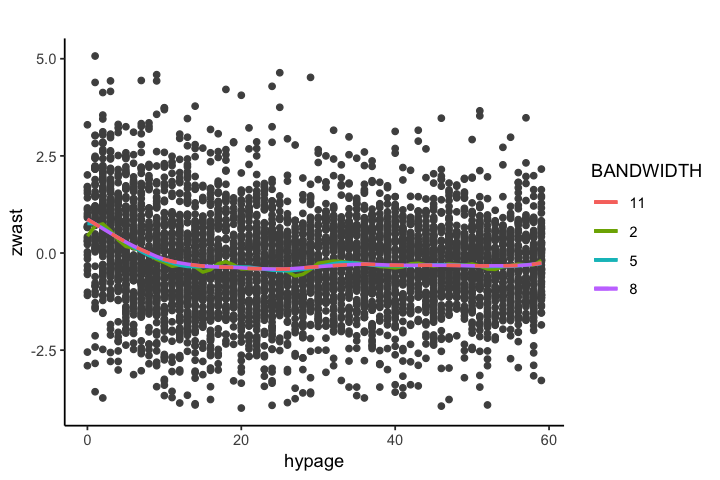

In [9]:
ggplot(children_subset, aes(x = hypage, y = zwast)) +
  geom_point(color = "gray31") +
  geom_line(data = df1, aes(x = a, y = b, color = "2"), size = 1) +
  geom_line(data = df2, aes(x = a, y = b, color = "5"), size = 1) +
  geom_line(data = df3, aes(x = a, y = b, color = "8"), size = 1) +
  geom_line(data = df3, aes(x = a, y = b, color = "11"), linetype = "dashed", size = 1) +
  labs(color = "Bandwidth") +
  labs(color = "Kernel") + labs(title = "",x = "hypage",y = "zwast", colour = "BANDWIDTH") + theme_classic()

In [14]:
#now with bw = 8, we fix the polynomial degree to 1, estimate f with 4 kernels from exercise 6
fit.5 <- local_polynomial(children_subset$zwast, children_subset$hypage, bw = 8, l = 1, kernel = "epanechnikov")
fit.6 <- local_polynomial(children_subset$zwast, children_subset$hypage, bw = 8, l = 1, kernel = "uniform")
fit.7 <- local_polynomial(children_subset$zwast, children_subset$hypage, bw = 8, l = 1, kernel = "triangular")
fit.8 <- local_polynomial(children_subset$zwast, children_subset$hypage, bw = 8, l = 1, kernel = "gaussian")
#Fitting on the domain of hypage = 0:59
dfit.5 <- fit.5(x = 0:maximum, derivative = 0)
dfit.6 <- fit.6(x = 0:maximum, derivative = 0)
dfit.7 <- fit.7(x = 0:maximum, derivative = 0)
dfit.8 <- fit.8(x = 0:maximum, derivative = 0)

#dataframes for ggplot
df5 <- data.frame(a = 0:maximum, b = dfit.5)
df6 <- data.frame(a = 0:maximum, b = dfit.6)
df7 <- data.frame(a = 0:maximum, b = dfit.7)
df8 <- data.frame(a = 0:maximum, b = dfit.8)

Don't know how to automatically pick scale for object of type labelled. Defaulting to continuous.


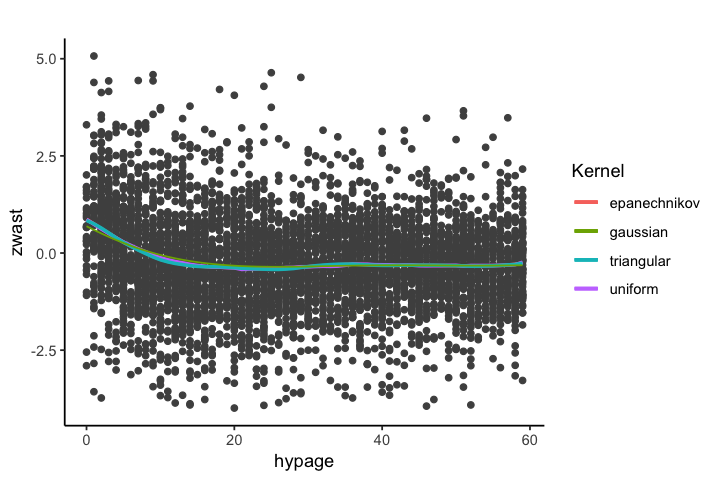

In [15]:
ggplot(children_subset, aes(x = hypage, y = zwast)) +
  geom_point(color = "gray31") +
  geom_line(data = df5, aes(x = a, y = b, color = "epanechnikov"), size = 1) +
  geom_line(data = df6, aes(x = a, y = b, color = "uniform"), size = 1) +
  geom_line(data = df7, aes(x = a, y = b, color = "triangular"), size = 1) +
  geom_line(data = df8, aes(x = a, y = b, color = "gaussian"),  size = 0.5) +
  labs(color = "Kernel") + labs(title = "",x = "hypage",y = "zwast", colour = "Kernel") + theme_classic()

In [16]:
GCV <- function(Y, X, bw, l){
  # Y = covariate; X = response variable; bw = bandwidth; l = polynomial degree
  X_values <- unique(sort(X))
  n <- length(Y)
  # Precomputation of matrices X(x_i) in formula for the estimator A_hat
  X_mat_list <- list()
  for (i in X_values){
    index = which(X_values == i)
    X_mat_list[[index]] = matrix(0, n, 4+1)
    aux = (X - i)
    for (j in 0:4){
      X_mat_list[[index]][, j+1] = aux**j
    }
  }
  
  sum_square = rep(0, length(X_values)) # MSE of Y vs fitted values of X
  W_trace = matrix(0, length(X_values)) # Sum of trace values of weight function W
  
  poly_fit = local_polynomial(Y, X, bw, l)
  
  # Calculate components of W_trace and sum_square
  for (i in X_values){
    index = which(X_values == i)
    aux = (X - i)
    
    X_mat = X_mat_list[[index]][, 1:(l+1)]
    
    V = diag(epanechnikov(aux/bw))
    
    weight_vector = solve(t(X_mat) %*% V %*% X_mat) %*% t(X_mat) %*% V
    weight_vector = weight_vector[1, ]
    
    W_trace[index] = sum((X == i) * weight_vector)
    
    sum_square[index] = sum((Y[(X == i)] - poly_fit(i, deriv = 0))**2)
  }
  res = sum(sum_square)/(1 - sum(W_trace)/n)**2
  
  return(res)
  
}

In [17]:
#optimal bandwidth by GCV for polynomial degrees 1 to 4
Y <- children_subset$zwast
X <- children_subset$hypage

GCV1 <- Vectorize(function(bw){GCV(Y, X, bw, l = 1)})
GCV2 <- Vectorize(function(bw){GCV(Y, X, bw, l = 2)})
GCV3 <- Vectorize(function(bw){GCV(Y, X, bw, l = 3)})
GCV4 <- Vectorize(function(bw){GCV(Y, X, bw, l = 4)})

opt.GCV1 <- optimize(GCV1, interval = c(2, 11))$minimum
opt.GCV2 <- optimize(GCV2, interval = c(2, 11))$minimum
opt.GCV3 <- optimize(GCV3, interval = c(2, 11))$minimum
opt.GCV4 <- optimize(GCV4, interval = c(2, 11))$minimum

#Plot all four fits putting the curves on the same plot
# First, fits for each polynomial degree with the corresponding optimal bw
fit.9 <- local_polynomial(children_subset$zwast, children_subset$hypage, bw = opt.GCV1, l = 1, kernel = "epanechnikov")
fit.10 <- local_polynomial(children_subset$zwast, children_subset$hypage, bw = opt.GCV2, l = 2, kernel = "epanechnikov")
fit.11 <- local_polynomial(children_subset$zwast, children_subset$hypage, bw = opt.GCV3, l = 3, kernel = "epanechnikov")
fit.12 <- local_polynomial(children_subset$zwast, children_subset$hypage, bw = opt.GCV4, l = 4, kernel = "epanechnikov")

#Fitting on the domain of hypage = 0:59
dfit.9 <- fit.9(x = 0:maximum, derivative = 0)
dfit.10 <- fit.10(x = 0:maximum, derivative = 0)
dfit.11 <- fit.11(x = 0:maximum, derivative = 0)
dfit.12 <- fit.12(x = 0:maximum, derivative = 0)

#dataframes for ggplot
df9 <- data.frame(a = 0:maximum, b = dfit.9)
df10 <- data.frame(a = 0:maximum, b = dfit.10)
df11 <- data.frame(a = 0:maximum, b = dfit.11)
df12 <- data.frame(a = 0:maximum, b = dfit.12)

Don't know how to automatically pick scale for object of type labelled. Defaulting to continuous.


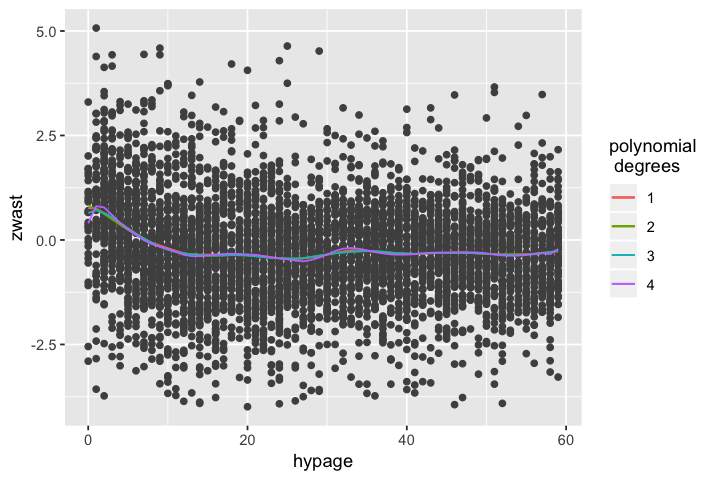

In [18]:
#Then the plot
ggplot(children_subset, aes(x = hypage, y = zwast)) +
  geom_point(color = "gray31") +
  geom_line(data = df9, aes(x = a, y = b, color = "1")) +
  geom_line(data = df10, aes(x = a, y = b, color = "2")) +
  geom_line(data = df11, aes(x = a, y = b, color = "3")) +
  geom_line(data = df12, aes(x = a, y = b, color = "4")) +
  labs(color = "polynomial \n degrees") 

In [1]:
fit.deriv.1 <- localpoly.reg(X, Y, bandwidth = 4.999956, degree.pol = 1, deriv = 1)
fit.deriv.2 <- localpoly.reg(X, Y, bandwidth = 10.99995, degree.pol = 2, deriv = 1)
fit.deriv.3 <- localpoly.reg(X, Y, bandwidth = 10.99994, degree.pol = 3, deriv = 1)
fit.deriv.4 <- localpoly.reg(X, Y, bandwidth = 8.403991, degree.pol = 4, deriv = 1)

#dataframes for ggplot
df13 <- data.frame(a = unique(fit.deriv.1$x), b = unique(fit.deriv.1$predict))
df14 <- data.frame(a = unique(fit.deriv.2$x), b = unique(fit.deriv.2$predict))
df15 <- data.frame(a = unique(fit.deriv.3$x), b = unique(fit.deriv.3$predict))
df16 <- data.frame(a = unique(fit.deriv.4$x), b = unique(fit.deriv.4$predict))

ERROR: Error in localpoly.reg(X, Y, bandwidth = 4.999956, degree.pol = 1, deriv = 1): could not find function "localpoly.reg"


In [ ]:
#Plot all four derivative fits on one plot
ggplot(children_subset, aes(x = hypage, y = zwast)) +
  geom_point(color = "gray31") +
  geom_line(data = df13, aes(x = a, y = b, color = "1")) +
  geom_line(data = df14, aes(x = a, y = b, color = "2")) +
  geom_line(data = df15, aes(x = a, y = b, color = "3")) +
  geom_line(data = df16, aes(x = a, y = b, color = "4")) +
  #ylim(-1, 1) +
  #xlim(2, 59)+
  labs(color = "polynomial \n degrees")